In [1]:
# !pip install gymnasium[classic-control]
# !pip install swig
# !pip install wheel setuptools pip --upgrade
# !pip install gymnasium[box2d]
# !pip install stable-baselines3
# !pip install stable-baselines3[extra] --upgrade
# !pip install tqdm rich

# pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu


import torch
print(torch.__version__)
print(torch.cuda.is_available())

from IPython.display import display, Math, Latex
import random
import numpy as np
import torch
import torch.nn as nn
import gymnasium as gym 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import os
import time
from IPython.display import HTML
from matplotlib import animation
%matplotlib inline

from gymnasium.wrappers import RecordVideo
from gymnasium.wrappers import RecordVideo
import gymnasium
import stable_baselines3
from gymnasium.wrappers import RecordVideo
from stable_baselines3 import SAC
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env import VecFrameStack, VecVideoRecorder
from stable_baselines3.common.callbacks import BaseCallback, EvalCallback
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.vec_env import VecTransposeImage
from stable_baselines3.common.atari_wrappers import WarpFrame

import os
import numpy
import platform
import matplotlib
import matplotlib.pyplot
import torch
from importlib.metadata import version

from utils.utils import *

2.7.1
False


In [20]:
gray_scale = True
wrapper_class = WarpFrame if gray_scale else None

env_str = "CarRacing-v3"

# WarpFrame - converts to grayscale 
env = make_vec_env(env_str, n_envs=1, wrapper_class=wrapper_class)
env.observation_space.shape  # 84, 84, 1)
# Stack frames to create a state representation
env = VecFrameStack(env, n_stack=4)
env.observation_space.shape  # (84, 84, 4)  
# Transpose to channels first; 
# Needed for pytorch 
# [N, H, W, C] → [N, C, H, W]
env = VecTransposeImage(env)
env.observation_space.shape  # (4, 84, 84)


# Create Evaluation CarRacing environment
env_val = make_vec_env(env_str, n_envs=1, wrapper_class=wrapper_class)
env_val = VecFrameStack(env_val, n_stack=4)
env_val = VecTransposeImage(env_val)    


In [ ]:
policy = "CnnPolicy"
buffer_size = 1_000_000  # size of experience replay buffer
train_freq = 1
gradient_steps = 1
learning_starts = 50_000  
learning_rate = 1e-4  # learning rate for the optimizer
batch_size = 256 
ent_coef = 'auto_0.01'  # entropy coefficient for SAC

model = SAC(
    policy=policy, 
    env=env, 
    verbose=0, 
    buffer_size=buffer_size,
    device='cuda',
    train_freq=train_freq,
    gradient_steps=gradient_steps,
    learning_starts=learning_starts,
    learning_rate=learning_rate,
    batch_size=batch_size,
    ent_coef=ent_coef,
    )

/opt/anaconda3/lib/python3.12/site-packages/stable_baselines3/common/buffers.py:242: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 56.47GB > 4.86GB
  warnings.warn(


The following code will be commented out to avoid running it again <br>
It was used to train the model on a cloud service <br>
With 8 CPU, 45gb GPU, 45 RAM it took 5h to run 

In [4]:
run_id = time.strftime("%Y%m%d-%H%M%S")
log_dir = f"./logs/{env_str}/{run_id}/"

model.learn(
    total_timesteps=500_000, 
    progress_bar=True,
    callback=EvalCallback(
        env_val,
        eval_freq=50_000,
        render=False,
        deterministic=True,
        n_eval_episodes=10
        )
    )

Output()

Eval num_timesteps=50000, episode_reward=-24.79 +/- 12.45

Episode length: 1000.00 +/- 0.00

New best mean reward!

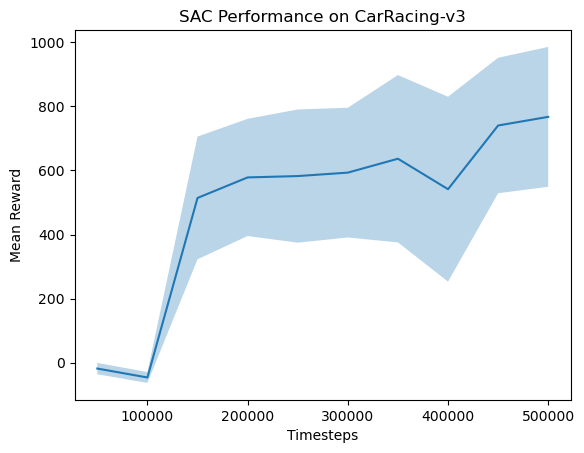

In [ ]:
log_dir = "logs/CarRacing-v3/model_2"

data = numpy.load(os.path.join(log_dir, "evaluations.npz"))

timesteps = data['timesteps']
results = data['results']

mean_results = numpy.mean(results, axis=1)
std_results = numpy.std(results, axis=1)

# Plot the results
matplotlib.pyplot.figure()
matplotlib.pyplot.plot(timesteps, mean_results)
matplotlib.pyplot.fill_between(timesteps,
                               mean_results - std_results,
                               mean_results + std_results,
                               alpha=0.3)

matplotlib.pyplot.xlabel("Timesteps")
matplotlib.pyplot.ylabel("Mean Reward")
matplotlib.pyplot.title(f"SAC Performance on {env_str}")
matplotlib.pyplot.show()

In [21]:
# Create Evaluation CarRacing environment
env = make_vec_env(env_str, n_envs=1, seed=0, wrapper_class=WarpFrame)
env = VecFrameStack(env, n_stack=4)
env = VecTransposeImage(env)

In [23]:
# Load the best model and evaluate it
best_model_path = os.path.join(log_dir, "best_model.zip")
best_model = SAC.load(best_model_path, env=env)

/opt/anaconda3/lib/python3.12/site-packages/stable_baselines3/common/buffers.py:242: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 56.47GB > 3.56GB
  warnings.warn(


In [25]:
mean_reward, std_reward = evaluate_policy(best_model, env, n_eval_episodes=30)
print(f"Best Model - Mean reward: {mean_reward:.2f} +/- {std_reward:.2f}")
# SAC algo should be evaluated with deterministic=False because it was trained with stochastic actions

Best Model - Mean reward: 848.38 +/- 119.11


In [ ]:
# mean_reward, std_reward = evaluate_policy(best_model, env, n_eval_episodes=30, deterministic=True)
# print(f"Best Model - Mean reward: {mean_reward:.2f} +/- {std_reward:.2f}")

Best Model - Mean reward: 810.93 +/- 145.29


In [28]:
scores = []
for _ in range(30):
    returns, _ = evaluate_policy(best_model, env, n_eval_episodes=1, deterministic=False)
    scores.append(returns)


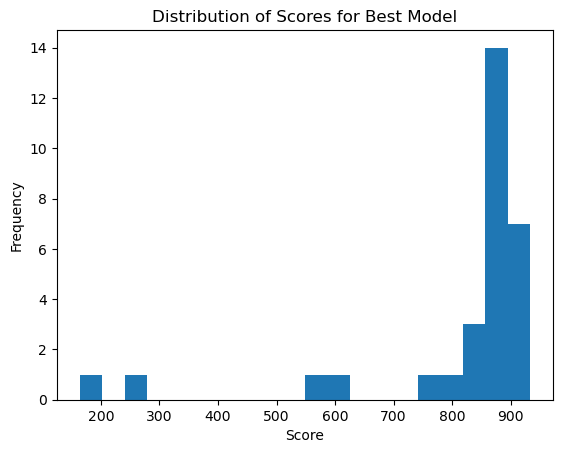

In [ ]:
# NON DETERMINISTIC POLICY
plt.hist(scores, bins=20)
plt.xlabel("Score")
plt.ylabel("Frequency")
plt.title("Distribution of Scores for Best Model")
plt.show()

In [29]:
scores_over_900 = [score for score in scores if score >= 900]
print(f"Percentage of episodes with score >= 900: {len(scores_over_900) / len(scores) * 100:.2f}%")

Percentage of episodes with score >= 900: 30.00%


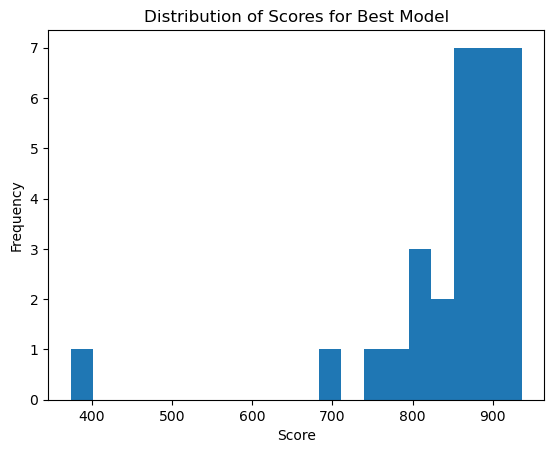

In [26]:
# DETERMINISTIC POLICY
scores = []
for _ in range(30):
    returns, _ = evaluate_policy(best_model, env, n_eval_episodes=1, deterministic=True)
    scores.append(returns)
    
plt.hist(scores, bins=20)
plt.xlabel("Score")
plt.ylabel("Frequency")
plt.title("Distribution of Scores for Best Model")
plt.show()



In [27]:
scores_over_900 = [score for score in scores if score >= 900]
print(f"Percentage of episodes with score >= 900: {len(scores_over_900) / len(scores) * 100:.2f}%")

Percentage of episodes with score >= 900: 23.33%


In [33]:
# Record video of the best model playing CarRacing
folder = "./videos/car_racing_sac"
env = VecVideoRecorder(env, folder,
                       video_length=10000,
                       record_video_trigger=lambda x: x == 0,
                       name_prefix="best_model_car_racing_sac")

obs = env.reset()
for _ in range(10000):
    action, _states = best_model.predict(obs, deterministic=True)
    obs, rewards, dones, info = env.step(action)
    env.render()
    if dones:
        break

env.close()


MoviePy - Building video /Users/gasparpereira/Desktop/MSc Data Science/2 semestre/Reinforcement Learning/Projeto/Notebooks/videos/car_racing_sac/best_model_car_racing_sac-step-0-to-step-10000.mp4.
MoviePy - Writing video /Users/gasparpereira/Desktop/MSc Data Science/2 semestre/Reinforcement Learning/Projeto/Notebooks/videos/car_racing_sac/best_model_car_racing_sac-step-0-to-step-10000.mp4



MoviePy - Done !
MoviePy - video ready /Users/gasparpereira/Desktop/MSc Data Science/2 semestre/Reinforcement Learning/Projeto/Notebooks/videos/car_racing_sac/best_model_car_racing_sac-step-0-to-step-10000.mp4


In [ ]:
from utils import *

In [34]:
latest_video = show_latest_video(video_folder=folder)
print("Played:", latest_video)

Played: ./videos/car_racing_sac/best_model_car_racing_sac-step-0-to-step-10000.mp4


# Comparison of algorithms

In [10]:
log_dir = "logs/CarRacing-v3/ppo_evaluations"
data = numpy.load(os.path.join(log_dir, "evaluations_model_3.npz"))
data

NpzFile 'logs/CarRacing-v3/ppo_evaluations/evaluations_model_3.npz' with keys: timesteps, results, ep_lengths

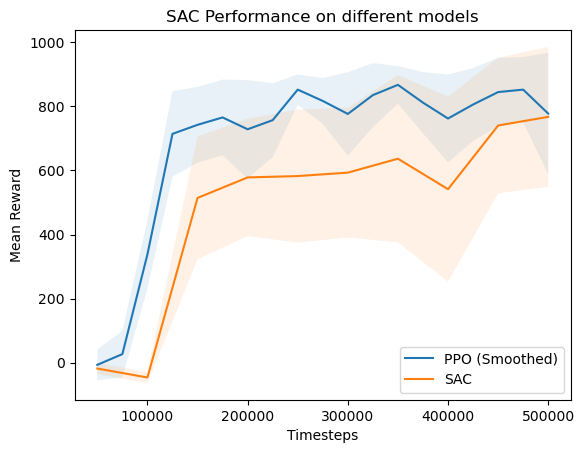

In [16]:
import pandas as pd

ppo_path = "logs/CarRacing-v3/ppo_evaluations/evaluations_model_3.npz"
ppo_data = np.load(ppo_path)
timesteps = ppo_data['timesteps']
results = ppo_data['results']  # shape: (n_evals, n_envs)

# Compute mean reward per evaluation
mean_results = results.mean(axis=1)
std_results = results.std(axis=1)

# Smooth with rolling average (window=2)
mean_smoothed = pd.Series(mean_results).rolling(window=2).mean().to_numpy()
std_smoothed = pd.Series(std_results).rolling(window=2).mean().to_numpy()

plt.plot(timesteps, mean_smoothed, label='PPO (Smoothed)')
plt.fill_between(timesteps,
                 mean_smoothed - std_smoothed,
                 mean_smoothed + std_smoothed,
                 alpha=0.1)


log_dir = "logs/CarRacing-v3/model_2"
data = numpy.load(os.path.join(log_dir, "evaluations.npz"))

timesteps = data['timesteps']
results = data['results']

mean_results = numpy.mean(results, axis=1)
std_results = numpy.std(results, axis=1)

# Plot the results
matplotlib.pyplot.plot(timesteps, mean_results, label='SAC')
matplotlib.pyplot.fill_between(timesteps,
                               mean_results - std_results,
                               mean_results + std_results,
                               alpha=0.1)

matplotlib.pyplot.xlabel("Timesteps")
matplotlib.pyplot.ylabel("Mean Reward")
matplotlib.pyplot.legend()
matplotlib.pyplot.title(f"SAC Performance on different models")
matplotlib.pyplot.show()